# Installs & Imports

In [1]:
!pip install -q snntorch tonic ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 65.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tonic
import tonic.transforms as transforms
from tonic import DiskCachedDataset

import torch
from torch.utils.data import random_split, Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

from tensorboard.backend.event_processing import event_accumulator

import snntorch as snn
from snntorch import surrogate, utils, spikegen
import snntorch.spikeplot as splt
from snntorch import functional as SF
from snntorch._layers.bntt import BatchNormTT1d, BatchNormTT2d

from sklearn.model_selection import train_test_split

import IPython.display as ipd
from IPython.display import HTML, display

import torchdata
import os
import zipfile
import time
import copy
import logging
import random
import pickle
from tqdm.notebook import tqdm

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Loading the Data

In [ ]:
# Define the path to the zip file and the extraction directory
zip_path = '/content/drive/My Drive/Datasets/STMNIST/STMNIST dataset NUS Tee Research Group.zip'
extract_path = '/content/drive/My Drive/Datasets/STMNIST'

# Unzip the file with progress bar
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    # Get a list of all files in the zip
    all_files = zip_ref.infolist()

    # Set up the progress bar
    with tqdm(total=len(all_files), desc="Extracting") as pbar:
        for file in all_files:
            # Extract each file
            zip_ref.extract(file, extract_path)

            # Update the progress bar
            pbar.update(1)

print('Files extracted to:', extract_path)

# List files to confirm
extracted_files = os.listdir(extract_path)
print(extracted_files)

# Define the root directory for the dataset
root = '/content/drive/My Drive/Datasets/'

Extracting:   0%|          | 0/6965 [00:00<?, ?it/s]

Files extracted to: /content/drive/My Drive/Datasets/STMNIST
['STMNIST dataset NUS Tee Research Group.zip', 'data_submission', 'STMNIST_extracted']


In [ ]:
# Load the dataset
dataset = tonic.prototype.datasets.STMNIST(root=root, keep_compressed=False, shuffle=False)

In [ ]:
# Save the dataset to a file
with open('/content/drive/My Drive/Datasets/STMNIST/STMNIST_dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)

In [ ]:
# Load the dataset from the file
with open('/content/drive/My Drive/Datasets/STMNIST/STMNIST_dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

# Exploring the Data

In [ ]:
# Get the number of samples in the dataset
num_samples = len(dataset)
print(f"Number of samples in the dataset: {num_samples}")

Number of samples in the dataset: 6953


In [ ]:
# Display the shape of the first event sample and its target
first_events, first_target = next(iter(dataset))

print(f"Number of events in the first sample: {len(first_events)}")
print(f"Shape of event data (x, y, t, p): {first_events[0]}")
print(f"Target (label) of the first sample: {first_target}")

# Explain the structure
print("\nEach event in the dataset has a structure (x, y, t, p), where x and y are spatial coordinates, t is the timestamp, and p is the polarity.")

Number of events in the first sample: 531
Shape of event data (x, y, t, p): (1, 5, 159950, 0)
Target (label) of the first sample: 8

Each event in the dataset has a structure (x, y, t, p), where x and y are spatial coordinates, t is the timestamp, and p is the polarity.


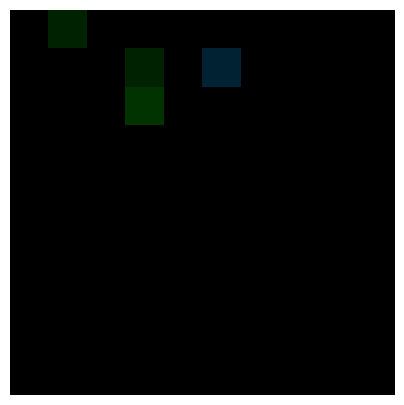

Sample 1 - Label: 6


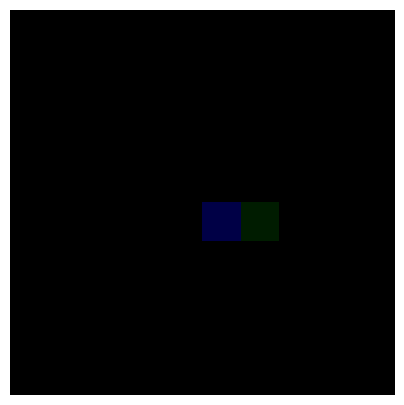

Sample 2 - Label: 1


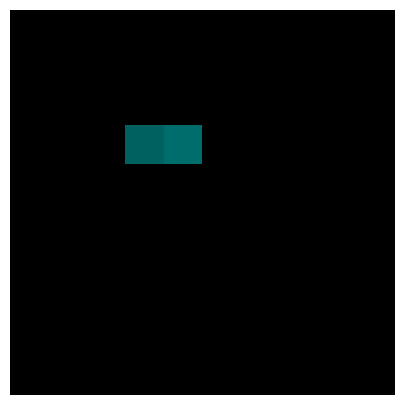

Sample 3 - Label: 2


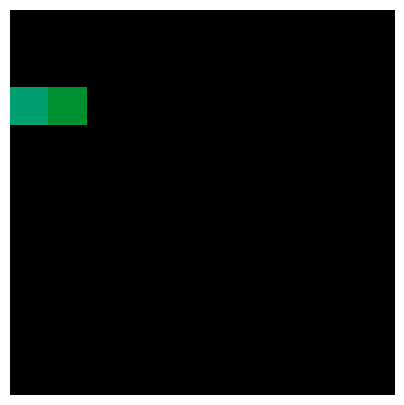

Sample 4 - Label: 3


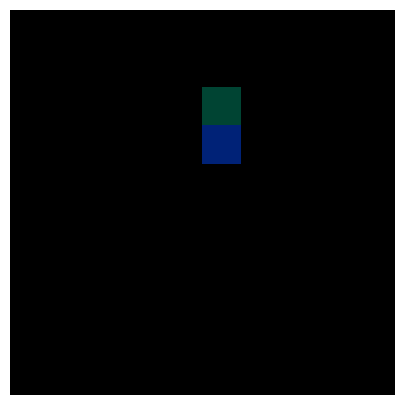

Sample 5 - Label: 1


In [ ]:
# Function to visualize sample animations
def visualize_st_mnist_samples(dataset, num_samples=5):
    # Ensure the dataset is loaded
    if not dataset:
        raise ValueError("Dataset is not provided or loaded.")

    # Check if num_samples is within the range of available samples in the dataset
    max_samples = len(dataset)
    if num_samples > max_samples:
        print(f"Requested number of samples ({num_samples}) exceeds the total available ({max_samples}). Showing {max_samples} samples instead.")
        num_samples = max_samples

    # Define the frame transform
    sensor_size = tuple(tonic.prototype.datasets.STMNIST.sensor_size.values())  # (10, 10, 2)
    frame_transform = transforms.Compose([
        transforms.Denoise(filter_time=10000),
        transforms.ToFrame(sensor_size=sensor_size, time_window=20000)
    ])

    # Select the first 'num_samples' from the dataset
    for index in range(num_samples):
        events, target = next(iter(dataset))

        # Apply frame transformation to the events
        frames = frame_transform(events)
        frames = frames / np.max(frames)
        frames = np.rot90(frames, k=-1, axes=(2, 3))
        frames = np.flip(frames, axis=3)

        # Create the animation
        animation = tonic.utils.plot_animation(frames)

        # Display the animation with a play button and interactive controls
        print(f"Sample {index + 1} - Label: {target}")
        display(HTML(animation.to_jshtml()))

# Call the function
visualize_st_mnist_samples(dataset, num_samples=5)

In [ ]:
# Function to visualize sample animations using spikeplot
def visualize_st_mnist_samples(dataset, num_samples=5):
    # Ensure the dataset is loaded
    if not dataset:
        raise ValueError("Dataset is not provided or loaded.")

    # Check if num_samples is within the range of available samples in the dataset
    max_samples = len(dataset)
    if num_samples > max_samples:
        print(f"Requested number of samples ({num_samples}) exceeds the total available ({max_samples}). Showing {max_samples} samples instead.")
        num_samples = max_samples

    # Define the frame transform for spikeplot visualization
    frame_transform_snntorch_visual = tonic.transforms.ToFrame(
        sensor_size=(10, 10, 2),
        time_window=8000,
    )

    # Select the first 'num_samples' from the dataset
    for index in range(num_samples):
        events, target = next(iter(dataset))

        # Apply frame transformation to the events
        tran = frame_transform_snntorch_visual(events)
        tran = np.rot90(tran, k=-1, axes=(2, 3))
        tran = np.flip(tran, axis=3)
        tran = torch.from_numpy(tran)

        tensor1 = tran[:, 0:1, :, :]
        tensor2 = tran[:, 1:2, :, :]

        print('Animation of ST-MNIST')
        print(f'The target label is: {target}')

        # Create a figure and axis for the animation
        fig, ax = plt.subplots()
        time_steps = tensor1.size(0)
        tensor1_plot = tensor1.reshape(time_steps, 10, 10)

        # Create the animation
        anim = splt.animator(tensor1_plot, fig, ax, interval=10)

        # Close the figure to prevent displaying the static image
        plt.close(fig)

        # Display the animation
        display(HTML(anim.to_html5_video()))

# Call the function
visualize_st_mnist_samples(dataset, num_samples=5)

Animation of ST-MNIST
The target label is: 5


Animation of ST-MNIST
The target label is: 2


Animation of ST-MNIST
The target label is: 2


Animation of ST-MNIST
The target label is: 3


Animation of ST-MNIST
The target label is: 9


In [ ]:
# Function to get events and targets
def extract_events_and_targets(dataset):
    all_events = []
    all_targets = []

    with tqdm(total=len(dataset) * 2, desc="Extracting events and targets") as pbar:
        for events, target in dataset:
            all_events.append(events)
            all_targets.append(target)
            pbar.update(1)

    return all_events, all_targets

# Call the function
all_events, all_targets = extract_events_and_targets(dataset)

Extracting events and targets:   0%|          | 0/13906 [00:00<?, ?it/s]

Processing events for distribution:   0%|          | 0/13906 [00:00<?, ?it/s]

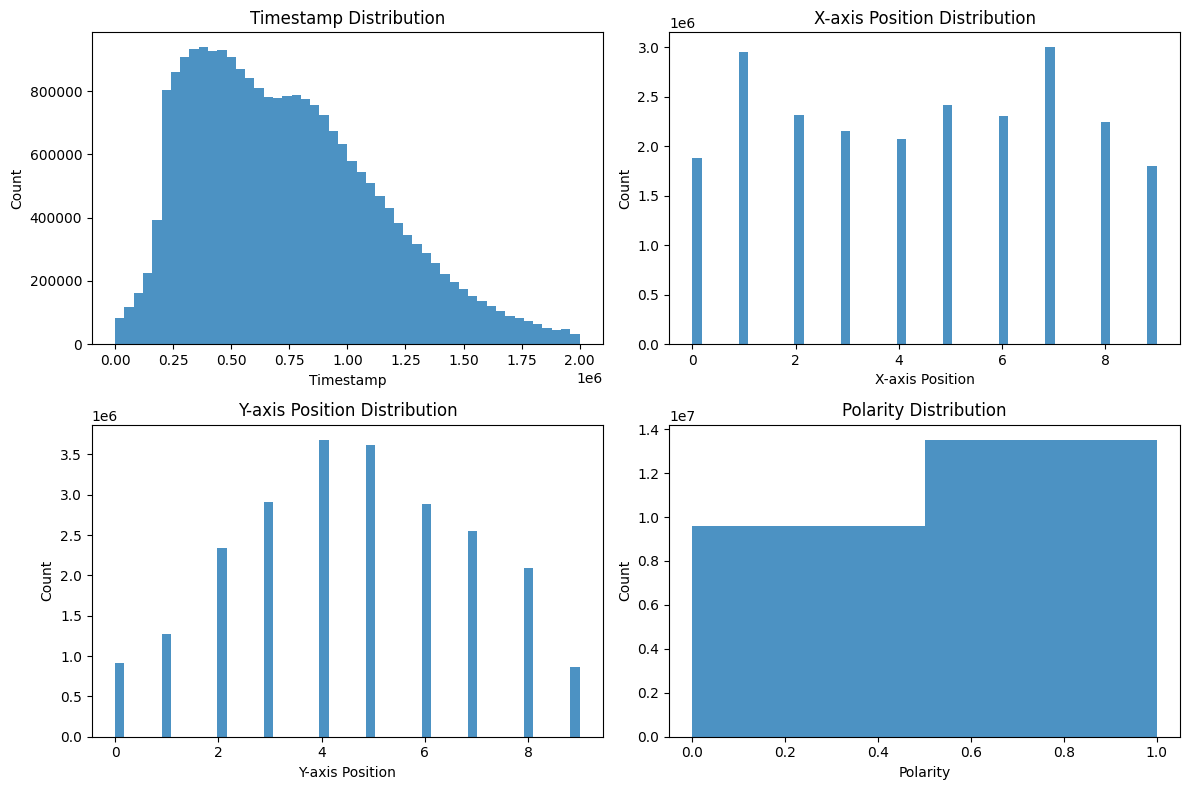

In [ ]:
# Function to visualize events
def visualize_event_distribution(all_events):
    timestamps = []
    x_positions = []
    y_positions = []
    polarities = []

    for events in tqdm(all_events, desc="Processing events for distribution"):
        for event in events:
            x, y, t, p = event
            timestamps.append(t)
            x_positions.append(x)
            y_positions.append(y)
            polarities.append(p)

    fig, axs = plt.subplots(2, 2, figsize=(12, 8))
    axs[0, 0].hist(timestamps, bins=50, alpha=0.8)
    axs[0, 0].set_xlabel('Timestamp')
    axs[0, 0].set_ylabel('Count')
    axs[0, 0].set_title('Timestamp Distribution')

    axs[0, 1].hist(x_positions, bins=50, alpha=0.8)
    axs[0, 1].set_xlabel('X-axis Position')
    axs[0, 1].set_ylabel('Count')
    axs[0, 1].set_title('X-axis Position Distribution')

    axs[1, 0].hist(y_positions, bins=50, alpha=0.8)
    axs[1, 0].set_xlabel('Y-axis Position')
    axs[1, 0].set_ylabel('Count')
    axs[1, 0].set_title('Y-axis Position Distribution')

    axs[1, 1].hist(polarities, bins=2, alpha=0.8)
    axs[1, 1].set_xlabel('Polarity')
    axs[1, 1].set_ylabel('Count')
    axs[1, 1].set_title('Polarity Distribution')

    plt.tight_layout()
    plt.show()

# Call the function
visualize_event_distribution(all_events)

Analyzing class distribution:   0%|          | 0/13906 [00:00<?, ?it/s]

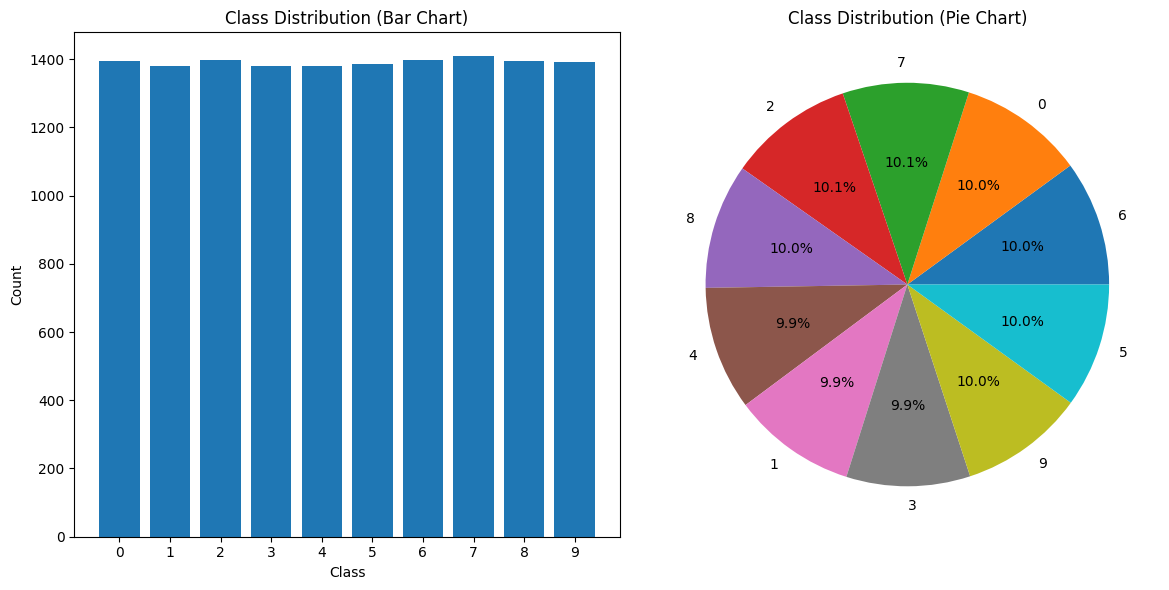

In [ ]:
# Function to examine class distribution
def explore_class_distribution(all_targets):
    class_counts = {}

    for target in tqdm(all_targets, desc="Analyzing class distribution"):
        class_counts[target] = class_counts.get(target, 0) + 1

    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.bar(classes, counts)
    ax1.set_xlabel('Class')
    ax1.set_ylabel('Count')
    ax1.set_title('Class Distribution (Bar Chart)')
    ax1.set_xticks(classes)

    ax2.pie(counts, labels=classes, autopct='%1.1f%%')
    ax2.set_title('Class Distribution (Pie Chart)')

    plt.tight_layout()
    plt.show()

# Call the function
explore_class_distribution(all_targets)

In [ ]:
# Function to get statistics
def compute_event_statistics(all_events, all_targets):
    num_events_per_sample = [len(events) for events in all_events]
    num_events_per_class = {i: [] for i in range(10)}

    timestamps = []
    x_positions = []
    y_positions = []

    for events, target in tqdm(zip(all_events, all_targets), total=len(all_events), desc="Computing event statistics"):
        num_events_per_class[target].append(len(events))
        for event in events:
            x, y, t, _ = event
            timestamps.append(t)
            x_positions.append(x)
            y_positions.append(y)

    print("Event Statistics:")
    print(f"Average number of events per sample: {np.mean(num_events_per_sample):.2f}")
    for cls in range(10):
        print(f"Average number of events for class {cls}: {np.mean(num_events_per_class[cls]):.2f}")
    print(f"Minimum number of events in a sample: {np.min(num_events_per_sample)}")
    print(f"Maximum number of events in a sample: {np.max(num_events_per_sample)}")
    print(f"Mean timestamp: {np.mean(timestamps):.2f}")
    print(f"Stddev timestamp: {np.std(timestamps):.2f}")
    print(f"Mean x-position: {np.mean(x_positions):.2f}")
    print(f"Stddev x-position: {np.std(x_positions):.2f}")
    print(f"Mean y-position: {np.mean(y_positions):.2f}")
    print(f"Stddev y-position: {np.std(y_positions):.2f}")

# Call the function
compute_event_statistics(all_events, all_targets)

Computing event statistics:   0%|          | 0/13906 [00:00<?, ?it/s]

Event Statistics:
Average number of events per sample: 1661.66
Average number of events for class 0: 2886.05
Average number of events for class 1: 610.49
Average number of events for class 2: 1506.96
Average number of events for class 3: 1869.06
Average number of events for class 4: 1425.32
Average number of events for class 5: 1939.24
Average number of events for class 6: 1291.54
Average number of events for class 7: 1352.11
Average number of events for class 8: 2406.44
Average number of events for class 9: 1323.22
Minimum number of events in a sample: 124
Maximum number of events in a sample: 39025
Mean timestamp: 737097.38
Stddev timestamp: 399006.22
Mean x-position: 4.47
Stddev x-position: 2.81
Mean y-position: 4.63
Stddev y-position: 2.30


Exploring event polarity:   0%|          | 0/5 [00:00<?, ?it/s]

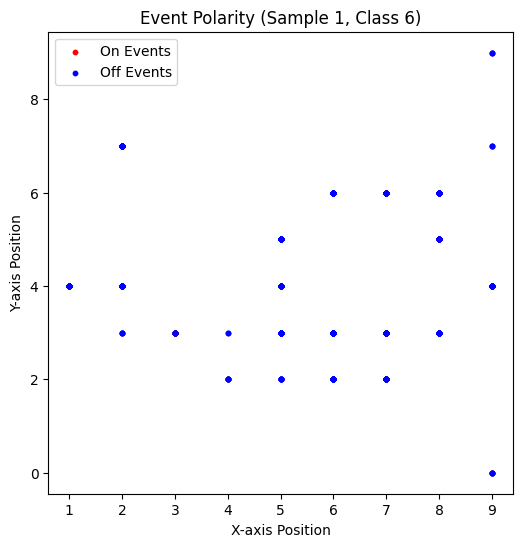

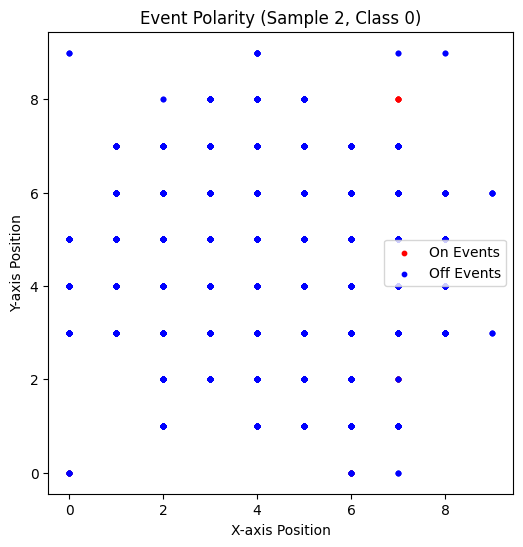

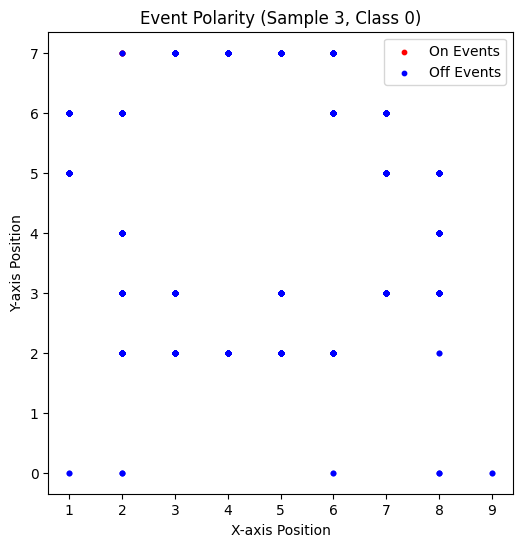

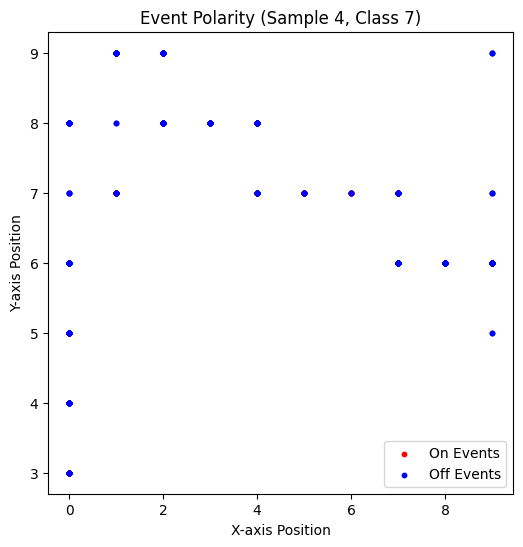

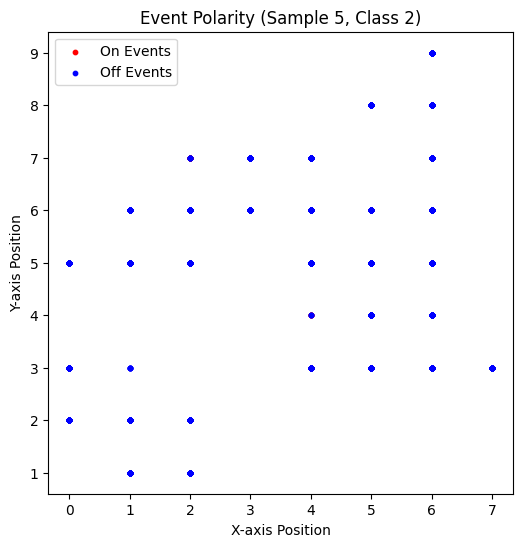

In [ ]:
# Function to examine event polarity
def explore_event_polarity(all_events, all_targets, num_samples=5):
    # Limit the number of samples to the minimum between num_samples and length of all_events
    num_samples = min(num_samples, len(all_events))

    with tqdm(total=num_samples, desc="Exploring event polarity") as pbar:
        for i in range(num_samples):
            events = all_events[i]
            target = all_targets[i]

            on_events = [event for event in events if event[3] == 1]
            off_events = [event for event in events if event[3] == 0]

            plt.figure(figsize=(6, 6))
            plt.scatter([event[0] for event in on_events], [event[1] for event in on_events], s=10, c='red', label='On Events')
            plt.scatter([event[0] for event in off_events], [event[1] for event in off_events], s=10, c='blue', label='Off Events')
            plt.title(f'Event Polarity (Sample {i+1}, Class {target})')
            plt.xlabel('X-axis Position')
            plt.ylabel('Y-axis Position')
            plt.legend()
            plt.show()
            pbar.update(1)

# Call the function
explore_event_polarity(all_events, all_targets, num_samples=5)

Visualizing event heatmaps:   0%|          | 0/5 [00:00<?, ?it/s]

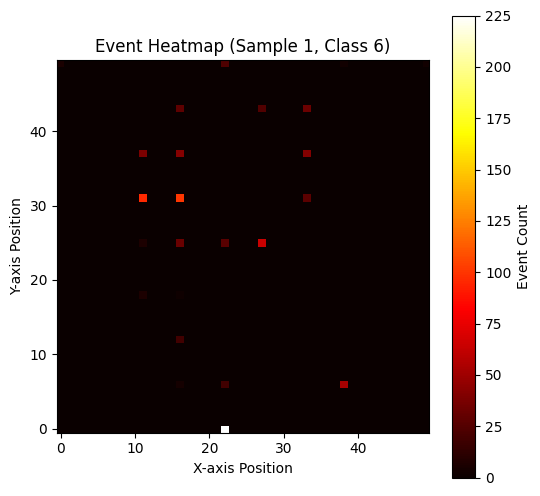

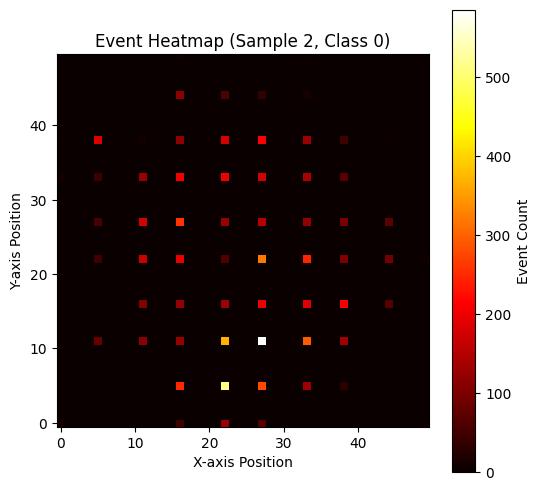

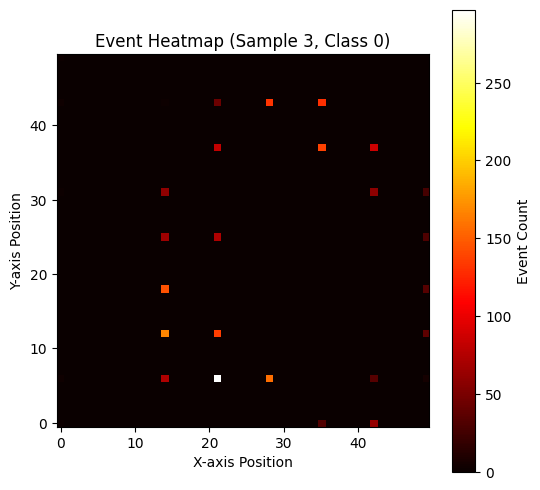

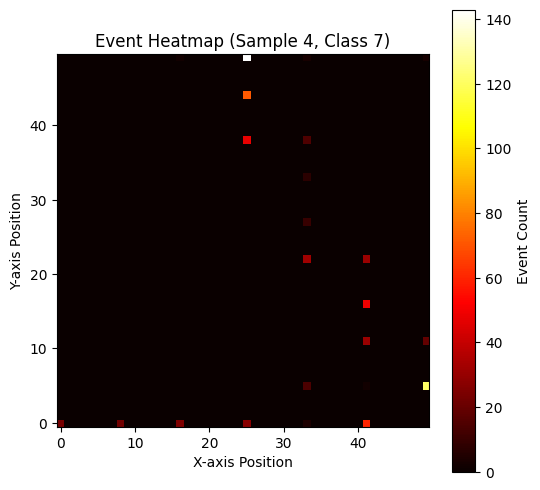

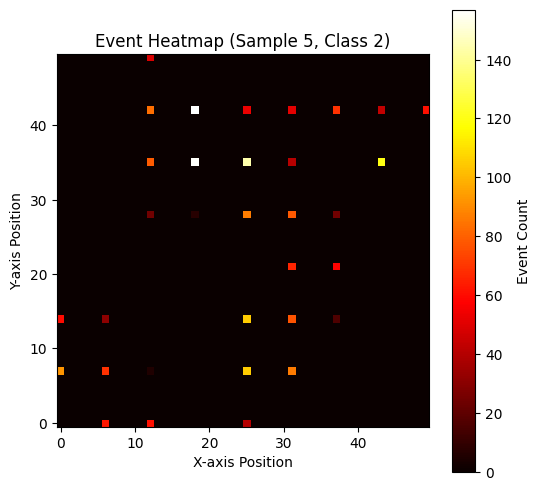

In [ ]:
# Function to see event heatmaps
def visualize_event_heatmaps(all_events, all_targets, num_samples=5):
    num_samples = min(num_samples, len(all_events))

    with tqdm(total=num_samples, desc="Visualizing event heatmaps") as pbar:
        for i in range(num_samples):
            events = all_events[i]
            target = all_targets[i]
            x_coords = [event[0] for event in events]
            y_coords = [event[1] for event in events]

            heatmap, _, _ = np.histogram2d(x_coords, y_coords, bins=50)

            plt.figure(figsize=(6, 6))
            plt.imshow(heatmap, cmap='hot', origin='lower')
            plt.colorbar(label='Event Count')
            plt.title(f'Event Heatmap (Sample {i+1}, Class {target})')
            plt.xlabel('X-axis Position')
            plt.ylabel('Y-axis Position')
            plt.show()
            pbar.update(1)

# Call the function
visualize_event_heatmaps(all_events, all_targets, num_samples=5)

Analyzing event timings:   0%|          | 0/5 [00:00<?, ?it/s]

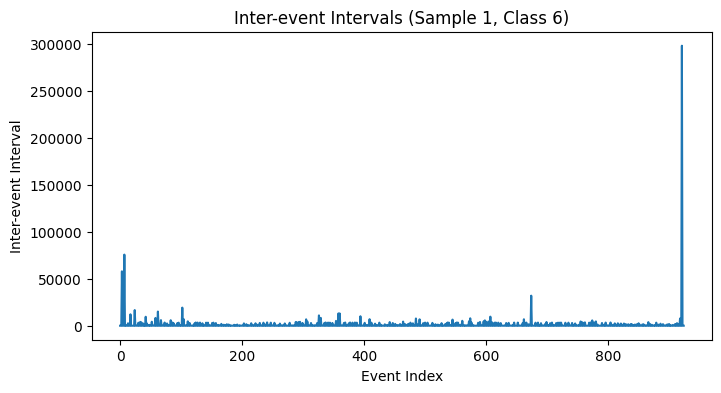

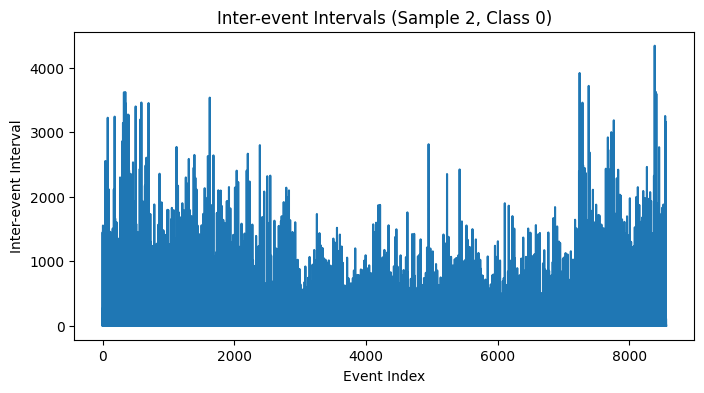

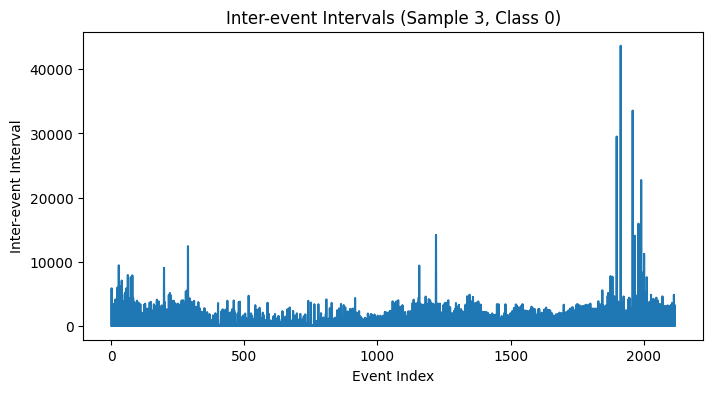

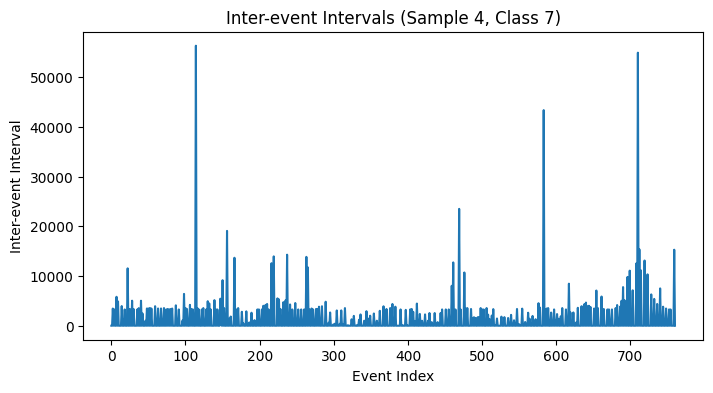

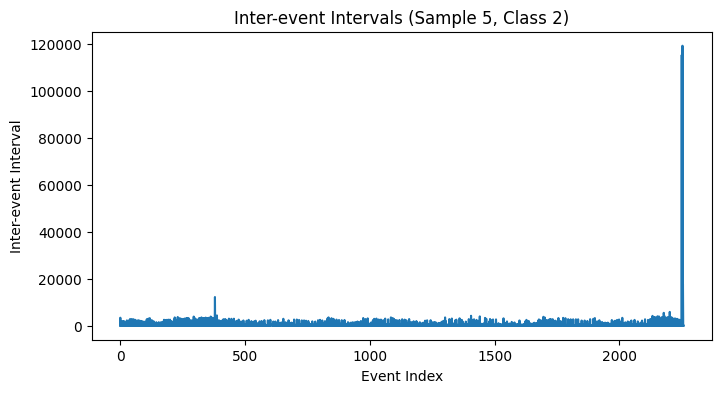

In [ ]:
# Function to examine event timings
def analyze_event_timings(all_events, all_targets, num_samples=5):
    num_samples = min(num_samples, len(all_events))

    with tqdm(total=num_samples, desc="Analyzing event timings") as pbar:
        for i in range(num_samples):
            events = all_events[i]
            target = all_targets[i]
            timestamps = [event[2] for event in events]
            inter_event_intervals = np.diff(timestamps)

            plt.figure(figsize=(8, 4))
            plt.plot(inter_event_intervals)
            plt.title(f'Inter-event Intervals (Sample {i+1}, Class {target})')
            plt.xlabel('Event Index')
            plt.ylabel('Inter-event Interval')
            plt.show()
            pbar.update(1)

# Call the function
analyze_event_timings(all_events, all_targets, num_samples=5)

# Creating DataLoaders

In [ ]:
# Define the sensor size
sensor_size = tonic.prototype.datasets.STMNIST.sensor_size
sensor_size = tuple(sensor_size.values())
print(sensor_size)

(10, 10, 2)


In [ ]:
# Define the ToFrame transformation
time_window = 20000
transform = transforms.Compose([
    transforms.ToFrame(sensor_size=sensor_size, time_window=time_window)
])

In [ ]:
# Function to transform the dataset
def transform_STMNIST(dataset, transform):
    transformed_dataset = []
    for events, target in tqdm(dataset, total=len(dataset) * 2, desc="Transforming dataset"):
        transformed_events = transform(events)
        transformed_dataset.append((transformed_events, target))
    return transformed_dataset

# Call the function
transformed_dataset = transform_STMNIST(dataset, transform)

Transforming dataset:   0%|          | 0/13906 [00:00<?, ?it/s]

In [ ]:
# Save the transformed dataset to a file
with open('/content/drive/My Drive/Datasets/STMNIST/STMNIST_transformed_dataset.pkl', 'wb') as f:
    pickle.dump(transformed_dataset, f)

In [3]:
# Load the transformed dataset from the file
with open('/content/drive/My Drive/Datasets/STMNIST/STMNIST_transformed_dataset.pkl', 'rb') as f:
    transformed_dataset = pickle.load(f)

In [4]:
# Stratified split of the data
train_set, temp_set = train_test_split(transformed_dataset, test_size=0.3, stratify=[t for _, t in transformed_dataset], random_state=42)
val_set, test_set = train_test_split(temp_set, test_size=0.5, stratify=[t for _, t in temp_set], random_state=42)

In [5]:
# Cache directory
cache_dir = './cache/stmnist'
os.makedirs(cache_dir, exist_ok=True)

In [6]:
# Cache datasets on disk
from_np_transform = transforms.Compose([torch.from_numpy])

cached_trainset = DiskCachedDataset(train_set, transform=from_np_transform, cache_path=os.path.join(cache_dir, 'train'))
cached_valset = DiskCachedDataset(val_set, cache_path=os.path.join(cache_dir, 'val'))
cached_testset = DiskCachedDataset(test_set, cache_path=os.path.join(cache_dir, 'test'))

In [7]:
# Create DataLoaders
batch_size = 32
num_workers = 2
collate_fn = tonic.collation.PadTensors(batch_first=False)

train_loader = DataLoader(cached_trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn)
val_loader = DataLoader(cached_valset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)
test_loader = DataLoader(cached_testset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn)

In [8]:
# Print the shapes
data_tensor, targets = next(iter(train_loader))
print(data_tensor.shape)

torch.Size([89, 32, 2, 10, 10])


In [9]:
# Function to check DataLoader dimensions
def check_dataloader_dimensions(dataloader, name):
    print(f"Checking dimensions for {name} dataloader:")
    for i, (data, target) in enumerate(dataloader):
        if i >= 3:
            break
        print(f"Batch {i+1}:")
        print(f"  Data shape: {data.shape}")
        print(f"  Target shape: {target.shape}")
    print()

# Call the function
check_dataloader_dimensions(train_loader, "Training")
check_dataloader_dimensions(val_loader, "Validation")
check_dataloader_dimensions(test_loader, "Testing")

Checking dimensions for Training dataloader:
Batch 1:
  Data shape: torch.Size([97, 32, 2, 10, 10])
  Target shape: torch.Size([32])
Batch 2:
  Data shape: torch.Size([99, 32, 2, 10, 10])
  Target shape: torch.Size([32])
Batch 3:
  Data shape: torch.Size([89, 32, 2, 10, 10])
  Target shape: torch.Size([32])

Checking dimensions for Validation dataloader:
Batch 1:
  Data shape: torch.Size([97, 32, 2, 10, 10])
  Target shape: torch.Size([32])
Batch 2:
  Data shape: torch.Size([94, 32, 2, 10, 10])
  Target shape: torch.Size([32])
Batch 3:
  Data shape: torch.Size([98, 32, 2, 10, 10])
  Target shape: torch.Size([32])

Checking dimensions for Testing dataloader:
Batch 1:
  Data shape: torch.Size([98, 32, 2, 10, 10])
  Target shape: torch.Size([32])
Batch 2:
  Data shape: torch.Size([99, 32, 2, 10, 10])
  Target shape: torch.Size([32])
Batch 3:
  Data shape: torch.Size([98, 32, 2, 10, 10])
  Target shape: torch.Size([32])



# Building the Models

In [10]:
# BasicSNN class
class BasicSNN(nn.Module):
    def __init__(self, num_inputs, num_hidden1, num_hidden2, num_outputs, beta, spike_grad, num_steps):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_hidden1 = num_hidden1
        self.num_hidden2 = num_hidden2
        self.num_outputs = num_outputs
        self.beta = beta
        self.spike_grad = spike_grad
        self.num_steps = num_steps

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden1)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc2 = nn.Linear(num_hidden1, num_hidden2)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc3 = nn.Linear(num_hidden2, num_outputs)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad, output=True)

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spk3_rec = []
        mem3_rec = []

        # [time_steps, batch_size, channels, height, width]
        for step in range(x.size(0)):
            # Flatten spatial dimensions for each time step
            input_t = x[step].view(x.size(1), -1)  # Reshape to [batch_size, num_inputs]

            cur1 = self.fc1(input_t)
            spk1, mem1 = self.lif1(cur1, mem1)
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

In [11]:
# Convolutional SNN class
class ConvSNN(nn.Module):
    def __init__(self, input_channels, hidden_channels1, hidden_channels2, output_channels, kernel_size, beta, spike_grad, num_steps, height, width):
        super().__init__()
        self.input_channels = input_channels
        self.hidden_channels1 = hidden_channels1
        self.hidden_channels2 = hidden_channels2
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.beta = beta
        self.spike_grad = spike_grad
        self.num_steps = num_steps
        self.height = height
        self.width = width

        # Initialize layers
        self.conv1 = nn.Conv2d(self.input_channels, self.hidden_channels1, self.kernel_size, padding=self.kernel_size//2, bias=False)
        self.pool1 = nn.MaxPool2d(2)
        self.lif1 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False)

        self.conv2 = nn.Conv2d(self.hidden_channels1, self.hidden_channels2, self.kernel_size, padding=self.kernel_size//2, bias=False)
        self.pool2 = nn.MaxPool2d(2)
        self.lif2 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False)

        # Calculate the flattened size based on the known height and width
        flattened_size = self._get_flattened_size()

        self.fc = nn.Linear(flattened_size, self.output_channels)
        self.lif3 = snn.Leaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, output=True)

    def _get_flattened_size(self):
        # 2 pooling layers each reducing height and width by a factor of 2
        pooled_height = self.height // 4
        pooled_width = self.width // 4
        return self.hidden_channels2 * pooled_height * pooled_width

    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        spk3_rec = []
        mem3_rec = []

        # Iterate over time steps
        for step in range(x.size(0)):
            input_t = x[step]

            cur1 = self.conv1(input_t)
            spk1, mem1 = self.lif1(cur1, mem1)
            pooled1 = self.pool1(spk1)

            cur2 = self.conv2(pooled1)
            spk2, mem2 = self.lif2(cur2, mem2)
            pooled2 = self.pool2(spk2)

            flattened = pooled2.view(pooled2.size(0), -1)
            cur3 = self.fc(flattened)
            spk3, mem3 = self.lif3(cur3, mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

In [12]:
# Convolutional SNN class with normalization and dropout
class ConvNormDropSNN(nn.Module):
    def __init__(self, input_channels, hidden_channels1, hidden_channels2, output_channels, kernel_size, beta, spike_grad, num_steps, height, width, dropout_prob):
        super().__init__()
        self.input_channels = input_channels
        self.hidden_channels1 = hidden_channels1
        self.hidden_channels2 = hidden_channels2
        self.output_channels = output_channels
        self.kernel_size = kernel_size
        self.beta = beta
        self.spike_grad = spike_grad
        self.num_steps = num_steps
        self.height = height
        self.width = width
        self.dropout_prob = dropout_prob

        # Initialize layers
        self.conv1 = nn.Conv2d(self.input_channels, self.hidden_channels1, self.kernel_size, padding=self.kernel_size//2, bias=False)
        self.bn1 = BatchNormTT2d(hidden_channels1, num_steps)
        self.drop1 = nn.Dropout2d(p=self.dropout_prob)
        self.pool1 = nn.MaxPool2d(2)
        self.lif1 = snn.RLeaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, conv2d_channels=self.hidden_channels1, kernel_size=self.kernel_size)

        self.conv2 = nn.Conv2d(self.hidden_channels1, self.hidden_channels2, self.kernel_size, padding=self.kernel_size//2, bias=False)
        self.bn2 = BatchNormTT2d(hidden_channels2, num_steps)
        self.drop2 = nn.Dropout2d(p=self.dropout_prob)
        self.pool2 = nn.MaxPool2d(2)
        self.lif2 = snn.RLeaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, conv2d_channels=self.hidden_channels2, kernel_size=self.kernel_size)

        # Calculate the flattened size based on the known height and width
        flattened_size = self._get_flattened_size()

        self.fc = nn.Linear(flattened_size, self.output_channels)
        self.lif3 = snn.RLeaky(beta=self.beta, spike_grad=self.spike_grad, init_hidden=False, linear_features=self.output_channels, output=True)

    def _get_flattened_size(self):
        pooled_height = self.height // 4
        pooled_width = self.width // 4
        return self.hidden_channels2 * pooled_height * pooled_width

    def forward(self, x):
        spk1, mem1 = self.lif1.init_rleaky()
        spk2, mem2 = self.lif2.init_rleaky()
        spk3, mem3 = self.lif3.init_rleaky()

        spk3_rec = []
        mem3_rec = []

        # Iterate over time steps
        for step in range(x.size(0)):
            input_t = x[step]

            cur1 = self.conv1(input_t)
            cur1 = self.bn1[step](cur1) if step < len(self.bn1) else cur1
            cur1 = self.drop1(cur1)
            spk1, mem1 = self.lif1(cur1, mem=mem1)

            pooled1 = self.pool1(spk1)

            cur2 = self.conv2(pooled1)
            cur2 = self.bn2[step](cur2) if step < len(self.bn2) else cur2
            cur2 = self.drop2(cur2)
            spk2, mem2 = self.lif2(cur2, mem=mem2)

            pooled2 = self.pool2(spk2)

            flattened = pooled2.view(pooled2.size(0), -1)
            cur3 = self.fc(flattened)
            spk3, mem3 = self.lif3(cur3, mem=mem3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

# Training the Models

In [13]:
# Trainer class
class Trainer:
    def __init__(self, model, optimizer, loss_fn, device, log_dir, scheduler=None, print_every=1):
        self.model = model
        self.optimizer = optimizer
        self.loss_fn = loss_fn
        self.device = device
        self.scheduler = scheduler
        self.print_every = print_every
        self.log_dir = log_dir
        self.writer = SummaryWriter(log_dir=self.log_dir)
        self.best_val_loss = float('inf')

        # Set up logging
        self.logger = logging.getLogger(f"{__name__}.{id(self)}")
        self.logger.setLevel(logging.INFO)
        self.logger.propagate = False

        if not self.logger.handlers:
            console_handler = logging.StreamHandler()
            formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
            console_handler.setFormatter(formatter)
            self.logger.addHandler(console_handler)

    def train(self, train_loader, val_loader, num_epochs):
        start_time = time.time()

        for epoch in range(1, num_epochs + 1):
            self.model.train()
            train_loss = 0.0
            train_acc = 0.0

            with tqdm(train_loader, desc=f"Epoch {epoch}", unit="batch", leave=False) as train_epoch:
                for batch_idx, (data, targets) in enumerate(train_epoch):
                    data = data.to(self.device)
                    targets = targets.to(self.device)

                    self.optimizer.zero_grad()

                    spk_rec, mem_rec = self.model(data)

                    loss = loss_fn(spk_rec, targets)
                    loss.backward()
                    self.optimizer.step()

                    train_loss += loss.item()
                    acc = SF.accuracy_rate(spk_rec, targets)
                    train_acc += acc

                    # Update the progress bar
                    train_epoch.set_postfix(loss=loss.item(), acc=acc)

            # Compute average loss and accuracy for the epoch
            train_loss /= len(train_loader)
            train_acc /= len(train_loader)

            #  Evaluate on validation set
            val_loss, val_acc = self.evaluate(val_loader)

            # Log metrics once per epoch
            self.writer.add_scalar('Train/Loss', train_loss, epoch)
            self.writer.add_scalar('Train/Accuracy', train_acc, epoch)
            self.writer.add_scalar('Val/Loss', val_loss, epoch)
            self.writer.add_scalar('Val/Accuracy', val_acc, epoch)

            if epoch % self.print_every == 0:
                elapsed_time = time.time() - start_time
                self.logger.info(f"Epoch [{epoch}/{num_epochs}], Train Loss: {train_loss:.4f}, "
                                 f"Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
                                 f"Elapsed Time: {elapsed_time:.2f}s")

            # Save the best model based on validation loss
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                torch.save(self.model.state_dict(), f"{self.log_dir}/best_model.pth")

            # Learning rate reduction
            if self.scheduler:
                self.scheduler.step(val_loss)

        end_time = time.time()
        elapsed_time = end_time - start_time
        self.logger.info(f"Training completed in {elapsed_time:.2f} seconds.")

    def evaluate(self, data_loader):
        self.model.eval()
        total_loss = 0.0
        total_acc = 0.0

        with torch.no_grad():
            for data, targets in data_loader:
                data = data.to(self.device)
                targets = targets.to(self.device)

                spk_rec, mem_rec = self.model(data)

                loss = loss_fn(spk_rec, targets)
                acc = SF.accuracy_rate(spk_rec, targets)

                total_loss += loss.item()
                total_acc += acc

        avg_loss = total_loss / len(data_loader)
        avg_acc = total_acc / len(data_loader)
        return avg_loss, avg_acc

    def load_best_model(self):
        best_model_path = f"{self.log_dir}/best_model.pth"
        self.model.load_state_dict(torch.load(best_model_path, map_location=self.device))

In [14]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
# Batched data parameters for shape reference
sample_batch = next(iter(train_loader))
_, channels, height, width = sample_batch[0].shape[1:]

print(f"Batch size: {sample_batch[0].size(0)}")
print(f"Channels: {channels}")
print(f"Height: {height}")
print(f"Width: {width}")

Batch size: 91
Channels: 2
Height: 10
Width: 10


In [16]:
# Number of inputs
num_inputs = channels * height * width
print(f"Number of inputs: {num_inputs}")

Number of inputs: 200


In [17]:
# Other parameters
num_steps = 92
num_hidden1 = 128
num_hidden2 = 64
num_outputs = 10
beta = 0.9
spike_grad = surrogate.fast_sigmoid()
learning_rate = 0.001
input_channels = channels
hidden_channels1 = 16
hidden_channels2 = 32
output_channels = 10
kernel_size = 3
dropout_prob = 0.2

In [18]:
# Create the models
basic_snn_model = BasicSNN(num_inputs, num_hidden1, num_hidden2, num_outputs, beta, spike_grad, num_steps).to(device)
conv_snn_model = ConvSNN(input_channels, hidden_channels1, hidden_channels2, output_channels, kernel_size, beta, spike_grad, num_steps, height, width).to(device)
conv_snn_norm_dropout_model = ConvNormDropSNN(input_channels, hidden_channels1, hidden_channels2, output_channels, kernel_size, beta, spike_grad, num_steps, height, width, dropout_prob).to(device)

In [19]:
# Define the loss function and optimizer for each model
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)
#loss_fn = SF.ce_rate_loss()

optimizer_basic = torch.optim.Adam(basic_snn_model.parameters(), lr=learning_rate)
optimizer_conv = torch.optim.Adam(conv_snn_model.parameters(), lr=learning_rate)
optimizer_conv_norm_dropout = torch.optim.Adam(conv_snn_norm_dropout_model.parameters(), lr=learning_rate)

In [20]:
# Create instances of the Trainer class for each model
trainer_basic = Trainer(basic_snn_model, optimizer_basic, loss_fn, device, log_dir="logs/basic_snn")
trainer_conv = Trainer(conv_snn_model, optimizer_conv, loss_fn, device, log_dir="logs/conv_snn")
trainer_conv_norm_dropout = Trainer(conv_snn_norm_dropout_model, optimizer_conv_norm_dropout, loss_fn, device, log_dir="logs/conv_snn_norm_dropout")

In [21]:
# Train the models
num_epochs = 20
print_every = 1

trainer_basic.train(train_loader, val_loader, num_epochs)
trainer_conv.train(train_loader, val_loader, num_epochs)
trainer_conv_norm_dropout.train(train_loader, val_loader, num_epochs)

Epoch 1:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:30:38,831 - __main__.140132025738640 - INFO - Epoch [1/20], Train Loss: 3.3986, Train Acc: 0.3713, Val Loss: 2.3050, Val Acc: 0.5956, Elapsed Time: 84.81s


Epoch 2:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:32:02,436 - __main__.140132025738640 - INFO - Epoch [2/20], Train Loss: 1.9913, Train Acc: 0.7283, Val Loss: 1.8560, Val Acc: 0.7767, Elapsed Time: 168.42s


Epoch 3:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:33:25,818 - __main__.140132025738640 - INFO - Epoch [3/20], Train Loss: 1.6761, Train Acc: 0.8175, Val Loss: 1.6377, Val Acc: 0.8231, Elapsed Time: 251.80s


Epoch 4:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:34:49,174 - __main__.140132025738640 - INFO - Epoch [4/20], Train Loss: 1.4860, Train Acc: 0.8640, Val Loss: 1.4888, Val Acc: 0.8587, Elapsed Time: 335.16s


Epoch 5:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:36:13,066 - __main__.140132025738640 - INFO - Epoch [5/20], Train Loss: 1.3409, Train Acc: 0.8911, Val Loss: 1.3928, Val Acc: 0.8734, Elapsed Time: 419.05s


Epoch 6:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:37:36,877 - __main__.140132025738640 - INFO - Epoch [6/20], Train Loss: 1.2382, Train Acc: 0.9070, Val Loss: 1.2724, Val Acc: 0.8957, Elapsed Time: 502.86s


Epoch 7:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:39:00,126 - __main__.140132025738640 - INFO - Epoch [7/20], Train Loss: 1.1552, Train Acc: 0.9193, Val Loss: 1.2263, Val Acc: 0.8993, Elapsed Time: 586.11s


Epoch 8:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:40:24,488 - __main__.140132025738640 - INFO - Epoch [8/20], Train Loss: 1.0915, Train Acc: 0.9273, Val Loss: 1.1408, Val Acc: 0.9121, Elapsed Time: 670.47s


Epoch 9:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:41:48,561 - __main__.140132025738640 - INFO - Epoch [9/20], Train Loss: 1.0265, Train Acc: 0.9417, Val Loss: 1.0806, Val Acc: 0.9257, Elapsed Time: 754.54s


Epoch 10:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:43:12,204 - __main__.140132025738640 - INFO - Epoch [10/20], Train Loss: 0.9869, Train Acc: 0.9435, Val Loss: 1.0582, Val Acc: 0.9261, Elapsed Time: 838.19s


Epoch 11:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:44:36,652 - __main__.140132025738640 - INFO - Epoch [11/20], Train Loss: 0.9418, Train Acc: 0.9515, Val Loss: 1.0180, Val Acc: 0.9351, Elapsed Time: 922.63s


Epoch 12:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:46:00,965 - __main__.140132025738640 - INFO - Epoch [12/20], Train Loss: 0.9084, Train Acc: 0.9539, Val Loss: 0.9772, Val Acc: 0.9432, Elapsed Time: 1006.95s


Epoch 13:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:47:25,503 - __main__.140132025738640 - INFO - Epoch [13/20], Train Loss: 0.8787, Train Acc: 0.9579, Val Loss: 0.9768, Val Acc: 0.9336, Elapsed Time: 1091.49s


Epoch 14:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:48:49,395 - __main__.140132025738640 - INFO - Epoch [14/20], Train Loss: 0.8411, Train Acc: 0.9625, Val Loss: 0.9457, Val Acc: 0.9427, Elapsed Time: 1175.38s


Epoch 15:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:50:13,617 - __main__.140132025738640 - INFO - Epoch [15/20], Train Loss: 0.8192, Train Acc: 0.9668, Val Loss: 0.9195, Val Acc: 0.9451, Elapsed Time: 1259.60s


Epoch 16:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:51:38,083 - __main__.140132025738640 - INFO - Epoch [16/20], Train Loss: 0.7934, Train Acc: 0.9667, Val Loss: 0.8896, Val Acc: 0.9512, Elapsed Time: 1344.07s


Epoch 17:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:53:01,735 - __main__.140132025738640 - INFO - Epoch [17/20], Train Loss: 0.7750, Train Acc: 0.9721, Val Loss: 0.8760, Val Acc: 0.9470, Elapsed Time: 1427.72s


Epoch 18:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:54:26,125 - __main__.140132025738640 - INFO - Epoch [18/20], Train Loss: 0.7529, Train Acc: 0.9745, Val Loss: 0.8428, Val Acc: 0.9536, Elapsed Time: 1512.11s


Epoch 19:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:55:49,915 - __main__.140132025738640 - INFO - Epoch [19/20], Train Loss: 0.7302, Train Acc: 0.9758, Val Loss: 0.8357, Val Acc: 0.9550, Elapsed Time: 1595.90s


Epoch 20:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:57:14,086 - __main__.140132025738640 - INFO - Epoch [20/20], Train Loss: 0.7121, Train Acc: 0.9789, Val Loss: 0.8295, Val Acc: 0.9531, Elapsed Time: 1680.07s
2024-03-15 14:57:14,093 - __main__.140132025738640 - INFO - Training completed in 1680.08 seconds.


Epoch 1:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 14:58:49,950 - __main__.140132025743488 - INFO - Epoch [1/20], Train Loss: 3.8647, Train Acc: 0.2189, Val Loss: 3.0940, Val Acc: 0.4094, Elapsed Time: 95.85s


Epoch 2:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:00:25,382 - __main__.140132025743488 - INFO - Epoch [2/20], Train Loss: 2.6905, Train Acc: 0.5336, Val Loss: 2.4849, Val Acc: 0.6250, Elapsed Time: 191.28s


Epoch 3:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:02:01,429 - __main__.140132025743488 - INFO - Epoch [3/20], Train Loss: 2.2620, Train Acc: 0.6790, Val Loss: 2.1641, Val Acc: 0.6935, Elapsed Time: 287.33s


Epoch 4:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:03:37,929 - __main__.140132025743488 - INFO - Epoch [4/20], Train Loss: 2.0210, Train Acc: 0.7555, Val Loss: 1.9885, Val Acc: 0.7543, Elapsed Time: 383.83s


Epoch 5:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:05:14,464 - __main__.140132025743488 - INFO - Epoch [5/20], Train Loss: 1.8355, Train Acc: 0.8005, Val Loss: 1.8107, Val Acc: 0.8111, Elapsed Time: 480.37s


Epoch 6:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:06:50,419 - __main__.140132025743488 - INFO - Epoch [6/20], Train Loss: 1.7103, Train Acc: 0.8306, Val Loss: 1.7341, Val Acc: 0.8196, Elapsed Time: 576.32s


Epoch 7:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:08:26,543 - __main__.140132025743488 - INFO - Epoch [7/20], Train Loss: 1.6115, Train Acc: 0.8520, Val Loss: 1.6288, Val Acc: 0.8390, Elapsed Time: 672.45s


Epoch 8:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:10:02,014 - __main__.140132025743488 - INFO - Epoch [8/20], Train Loss: 1.5139, Train Acc: 0.8721, Val Loss: 1.5358, Val Acc: 0.8576, Elapsed Time: 767.92s


Epoch 9:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:11:36,888 - __main__.140132025743488 - INFO - Epoch [9/20], Train Loss: 1.4388, Train Acc: 0.8897, Val Loss: 1.4578, Val Acc: 0.8799, Elapsed Time: 862.79s


Epoch 10:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:13:12,525 - __main__.140132025743488 - INFO - Epoch [10/20], Train Loss: 1.3760, Train Acc: 0.9003, Val Loss: 1.4103, Val Acc: 0.8832, Elapsed Time: 958.43s


Epoch 11:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:14:47,824 - __main__.140132025743488 - INFO - Epoch [11/20], Train Loss: 1.3298, Train Acc: 0.9113, Val Loss: 1.3748, Val Acc: 0.8932, Elapsed Time: 1053.73s


Epoch 12:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:16:23,849 - __main__.140132025743488 - INFO - Epoch [12/20], Train Loss: 1.2910, Train Acc: 0.9163, Val Loss: 1.3210, Val Acc: 0.9026, Elapsed Time: 1149.75s


Epoch 13:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:17:58,662 - __main__.140132025743488 - INFO - Epoch [13/20], Train Loss: 1.2476, Train Acc: 0.9210, Val Loss: 1.3014, Val Acc: 0.8984, Elapsed Time: 1244.56s


Epoch 14:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:19:34,562 - __main__.140132025743488 - INFO - Epoch [14/20], Train Loss: 1.2173, Train Acc: 0.9277, Val Loss: 1.2767, Val Acc: 0.9088, Elapsed Time: 1340.46s


Epoch 15:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:21:10,449 - __main__.140132025743488 - INFO - Epoch [15/20], Train Loss: 1.1919, Train Acc: 0.9302, Val Loss: 1.2440, Val Acc: 0.9092, Elapsed Time: 1436.35s


Epoch 16:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:22:46,972 - __main__.140132025743488 - INFO - Epoch [16/20], Train Loss: 1.1657, Train Acc: 0.9331, Val Loss: 1.2356, Val Acc: 0.9140, Elapsed Time: 1532.87s


Epoch 17:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:24:22,874 - __main__.140132025743488 - INFO - Epoch [17/20], Train Loss: 1.1371, Train Acc: 0.9388, Val Loss: 1.1954, Val Acc: 0.9178, Elapsed Time: 1628.78s


Epoch 18:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:25:58,916 - __main__.140132025743488 - INFO - Epoch [18/20], Train Loss: 1.1223, Train Acc: 0.9373, Val Loss: 1.1655, Val Acc: 0.9268, Elapsed Time: 1724.82s


Epoch 19:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:27:34,625 - __main__.140132025743488 - INFO - Epoch [19/20], Train Loss: 1.1023, Train Acc: 0.9418, Val Loss: 1.1382, Val Acc: 0.9197, Elapsed Time: 1820.53s


Epoch 20:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:29:10,932 - __main__.140132025743488 - INFO - Epoch [20/20], Train Loss: 1.0868, Train Acc: 0.9424, Val Loss: 1.1358, Val Acc: 0.9239, Elapsed Time: 1916.83s
2024-03-15 15:29:10,938 - __main__.140132025743488 - INFO - Training completed in 1916.84 seconds.


Epoch 1:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:31:36,965 - __main__.140132025732016 - INFO - Epoch [1/20], Train Loss: 2.7871, Train Acc: 0.4351, Val Loss: 2.3154, Val Acc: 0.5997, Elapsed Time: 146.02s


Epoch 2:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:34:04,141 - __main__.140132025732016 - INFO - Epoch [2/20], Train Loss: 2.0934, Train Acc: 0.6916, Val Loss: 1.8645, Val Acc: 0.7557, Elapsed Time: 293.20s


Epoch 3:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:36:30,657 - __main__.140132025732016 - INFO - Epoch [3/20], Train Loss: 1.7391, Train Acc: 0.7918, Val Loss: 1.5580, Val Acc: 0.8395, Elapsed Time: 439.71s


Epoch 4:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:38:57,229 - __main__.140132025732016 - INFO - Epoch [4/20], Train Loss: 1.4730, Train Acc: 0.8494, Val Loss: 1.4473, Val Acc: 0.8349, Elapsed Time: 586.29s


Epoch 5:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:41:23,769 - __main__.140132025732016 - INFO - Epoch [5/20], Train Loss: 1.3038, Train Acc: 0.8787, Val Loss: 1.2727, Val Acc: 0.8711, Elapsed Time: 732.83s


Epoch 6:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:43:50,036 - __main__.140132025732016 - INFO - Epoch [6/20], Train Loss: 1.1586, Train Acc: 0.9013, Val Loss: 1.1158, Val Acc: 0.8979, Elapsed Time: 879.09s


Epoch 7:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:46:16,184 - __main__.140132025732016 - INFO - Epoch [7/20], Train Loss: 1.0658, Train Acc: 0.9129, Val Loss: 1.0074, Val Acc: 0.9113, Elapsed Time: 1025.24s


Epoch 8:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:48:42,353 - __main__.140132025732016 - INFO - Epoch [8/20], Train Loss: 0.9735, Train Acc: 0.9247, Val Loss: 0.9816, Val Acc: 0.9137, Elapsed Time: 1171.41s


Epoch 9:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:51:08,094 - __main__.140132025732016 - INFO - Epoch [9/20], Train Loss: 0.9084, Train Acc: 0.9312, Val Loss: 0.8330, Val Acc: 0.9293, Elapsed Time: 1317.15s


Epoch 10:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:53:34,139 - __main__.140132025732016 - INFO - Epoch [10/20], Train Loss: 0.8458, Train Acc: 0.9401, Val Loss: 0.8685, Val Acc: 0.9283, Elapsed Time: 1463.20s


Epoch 11:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:56:00,447 - __main__.140132025732016 - INFO - Epoch [11/20], Train Loss: 0.7972, Train Acc: 0.9450, Val Loss: 0.7799, Val Acc: 0.9317, Elapsed Time: 1609.50s


Epoch 12:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 15:58:26,146 - __main__.140132025732016 - INFO - Epoch [12/20], Train Loss: 0.7531, Train Acc: 0.9495, Val Loss: 0.7129, Val Acc: 0.9497, Elapsed Time: 1755.20s


Epoch 13:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 16:00:52,794 - __main__.140132025732016 - INFO - Epoch [13/20], Train Loss: 0.7223, Train Acc: 0.9498, Val Loss: 0.6872, Val Acc: 0.9440, Elapsed Time: 1901.85s


Epoch 14:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 16:03:18,978 - __main__.140132025732016 - INFO - Epoch [14/20], Train Loss: 0.6757, Train Acc: 0.9507, Val Loss: 0.6735, Val Acc: 0.9430, Elapsed Time: 2048.03s


Epoch 15:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 16:05:45,278 - __main__.140132025732016 - INFO - Epoch [15/20], Train Loss: 0.6707, Train Acc: 0.9528, Val Loss: 0.6342, Val Acc: 0.9473, Elapsed Time: 2194.34s


Epoch 16:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 16:08:13,264 - __main__.140132025732016 - INFO - Epoch [16/20], Train Loss: 0.6216, Train Acc: 0.9552, Val Loss: 0.6353, Val Acc: 0.9440, Elapsed Time: 2342.32s


Epoch 17:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 16:10:40,964 - __main__.140132025732016 - INFO - Epoch [17/20], Train Loss: 0.6155, Train Acc: 0.9543, Val Loss: 0.6121, Val Acc: 0.9407, Elapsed Time: 2490.02s


Epoch 18:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 16:13:09,130 - __main__.140132025732016 - INFO - Epoch [18/20], Train Loss: 0.5815, Train Acc: 0.9554, Val Loss: 0.5599, Val Acc: 0.9515, Elapsed Time: 2638.19s


Epoch 19:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 16:15:36,346 - __main__.140132025732016 - INFO - Epoch [19/20], Train Loss: 0.5712, Train Acc: 0.9559, Val Loss: 0.5426, Val Acc: 0.9545, Elapsed Time: 2785.40s


Epoch 20:   0%|          | 0/305 [00:00<?, ?batch/s]

2024-03-15 16:18:02,115 - __main__.140132025732016 - INFO - Epoch [20/20], Train Loss: 0.5293, Train Acc: 0.9563, Val Loss: 0.5255, Val Acc: 0.9514, Elapsed Time: 2931.17s
2024-03-15 16:18:02,175 - __main__.140132025732016 - INFO - Training completed in 2931.23 seconds.


# Plotting the Training

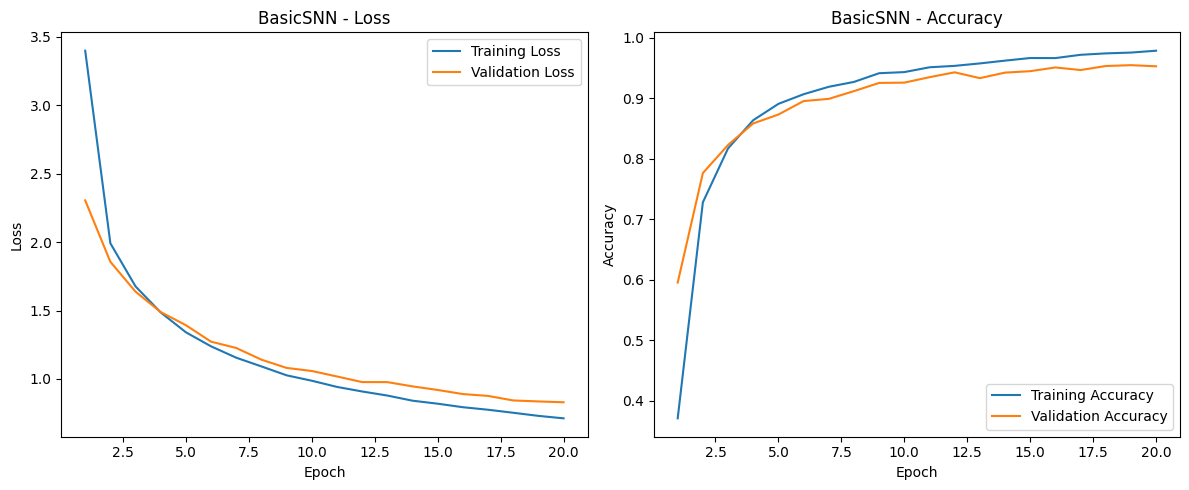

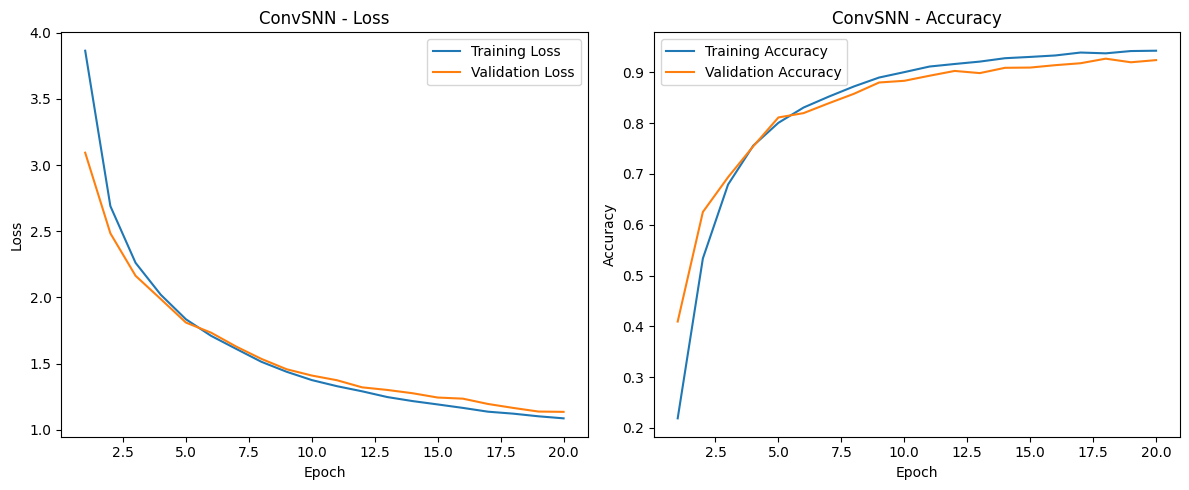

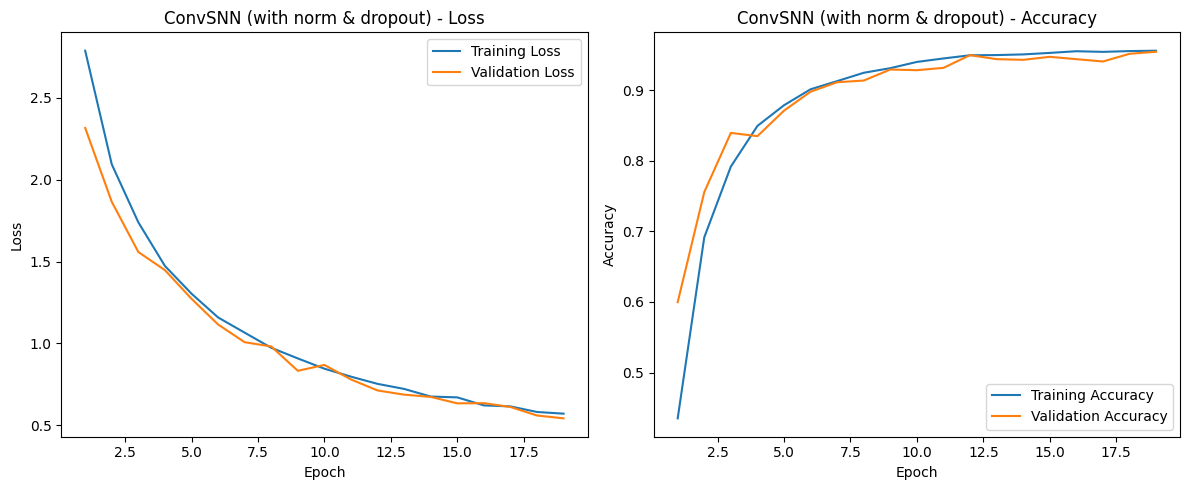

In [22]:
# Function to plot training metrics
def plot_metrics(log_dir, model_name):
    # Load the TensorBoard log data
    event_acc = event_accumulator.EventAccumulator(log_dir)
    event_acc.Reload()

    # Get the scalars for training loss and accuracy
    train_loss = event_acc.Scalars('Train/Loss')
    train_acc = event_acc.Scalars('Train/Accuracy')

    # Get the scalars for validation loss and accuracy
    val_loss = event_acc.Scalars('Val/Loss')
    val_acc = event_acc.Scalars('Val/Accuracy')

    # Create subplots for loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot training and validation loss
    ax1.plot([x.step for x in train_loss], [x.value for x in train_loss], label='Training Loss')
    ax1.plot([x.step for x in val_loss], [x.value for x in val_loss], label='Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{model_name} - Loss')
    ax1.legend()

    # Plot training and validation accuracy
    ax2.plot([x.step for x in train_acc], [x.value for x in train_acc], label='Training Accuracy')
    ax2.plot([x.step for x in val_acc], [x.value for x in val_acc], label='Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title(f'{model_name} - Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Call the function
plot_metrics("logs/basic_snn", "BasicSNN")
plot_metrics("logs/conv_snn", "ConvSNN")
plot_metrics("logs/conv_snn_norm_dropout", "ConvSNN (with norm & dropout)")

# Evaluating the Models

In [23]:
# Load the best models
trainer_basic.load_best_model()
trainer_conv.load_best_model()
trainer_conv_norm_dropout.load_best_model()

In [24]:
# Evaluate the trained models on the test set
test_loss_basic, test_acc_basic = trainer_basic.evaluate(test_loader)
test_loss_conv, test_acc_conv = trainer_conv.evaluate(test_loader)
test_loss_conv_norm_dropout, test_acc_conv_norm_dropout = trainer_conv_norm_dropout.evaluate(test_loader)

print(f"BasicSNN - Test Loss: {test_loss_basic:.4f}, Test Acc: {test_acc_basic:.4f}")
print(f"ConvSNN - Test Loss: {test_loss_conv:.4f}, Test Acc: {test_acc_conv:.4f}")
print(f"ConvNormDropSNN - Test Loss: {test_loss_conv_norm_dropout:.4f}, Test Acc: {test_acc_conv_norm_dropout:.4f}")

BasicSNN - Test Loss: 0.8374, Test Acc: 0.9549
ConvSNN - Test Loss: 1.1405, Test Acc: 0.9342
ConvNormDropSNN - Test Loss: 0.5211, Test Acc: 0.9522
